# Task 1

In [ ]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from pathlib import Path
prefix_dir = Path("../data")

In [ ]:
train_df = pd.read_csv(prefix_dir.joinpath("train.csv"), index_col=0)
train_df["date"] = pd.to_datetime(train_df["date"], format="%d.%m.%Y")
test_df = pd.read_csv(prefix_dir.joinpath("test.csv"), index_col=0)

### 1) Understand the data

__Check which category has lowest/highest amount__
- Check 1: That category has the most items, therefore it has highest amount?
    - The more items there are, the more sales will occur (obviously)
    - Some categories play a crucial role, like categories 30 and 19, because the ratio of sales by items is much higher than the top category (607, 407 vs 127).
    - This ratio indicates that the higher the category's ratio, the more effective its sales.

- Check 2: Why the category has very small amount of sales?
    - There are items open from 2013 but only one transaction made, may be that item has been abandoned

In [ ]:
t = train_df.copy()
t = t.groupby(by=["item_category_id"]).agg(
    total=pd.NamedAgg(column="item_cnt_day", aggfunc="sum"),
    count=pd.NamedAgg(column="item_id", aggfunc="nunique"),
    items=pd.NamedAgg(column="item_id", aggfunc="unique")
)
t["ratio"] = t["total"] / t["count"]
t.sort_values("total", ascending=[False])

In [ ]:
train_df[train_df["item_id"].isin([6669, 17703, 16834, 16835])]

__Price of items have changed over time?__
- Prices of some items have not changed but some have

In [ ]:
t = train_df[["item_id", "item_price"]].copy()
t.groupby("item_id").agg(
    count=pd.NamedAgg(aggfunc="nunique", column="item_price")
).reset_index().describe()

__On the same category, different shops have different sales?__
- We may need to build separate models for different shops & different category?
- Need to create some experiments later!

In [ ]:
t = train_df[train_df["item_category_id"] == 58].copy()
t = t.groupby(by=["shop_id", "date_block_num"]).agg(
    total=pd.NamedAgg(column="item_cnt_day", aggfunc="sum")
).reset_index()
plt.figure(figsize=(10, 4))
sns.lineplot(t, x="date_block_num", y="total", hue="shop_id")

__Do people usually spend more on weekend?__
- The sales is better on weekends overall

__Is there category perform worst on weekends?__
- When diving deep to category level, there are categories perform worst on weekends
- May be we need to build different models for different categories?

In [ ]:
train_df["date"].dt.weekday.value_counts()

In [ ]:
weekday_mapper = {
    0: "2-mon",
    1: "3-tue",
    2: "4-wed",
    3: "5-thu",
    4: "6-fri",
    5: "7-sat",
    6: "8-sun"
}
train_df["weekday"] = train_df["date"].dt.weekday
train_df["weekend"] = 0
train_df.loc[train_df["weekday"].isin([5, 6]), "weekend"] = 1
train_df["weekday"] = train_df["weekday"].map(weekday_mapper)

In [ ]:
t = train_df.copy()
t = t.groupby(by=["weekday"]).agg(
    total=pd.NamedAgg(column="item_cnt_day", aggfunc="sum")
).reset_index()
plt.figure(figsize=(4, 3))
sns.barplot(t, x="weekday", y="total")

In [ ]:
t = train_df.copy()
t = t.groupby(by=["item_category_id", "weekday", "weekend"]).agg(
    total=pd.NamedAgg(aggfunc="sum", column="item_cnt_day")
).reset_index()
t = t.groupby(by=["item_category_id", "weekend"]).agg(
    min=pd.NamedAgg(aggfunc="min", column="total"),
    max=pd.NamedAgg(aggfunc="max", column="total")
).reset_index()
t = t.pivot(index=["item_category_id"], columns=["weekend"], values=["max", "min"])
t.head(3)

In [ ]:
t[t["max"][0] > t["max"][1]].head(3)

In [ ]:
t[t["min"][0] > t["min"][1]].head(3)

__How the sales perform over months?__
- The sales outperforms in December

In [ ]:
t = train_df.copy()
t["ym"] = t["date"].dt.strftime("%Y-%m")
t = t.groupby(by=["ym"]).agg(
    total=pd.NamedAgg(column="item_cnt_day", aggfunc="sum")
)
plt.figure(figsize=(10, 4))
plt.xticks(rotation=45, ha="right")
sns.barplot(t, x="ym", y="total")

### 2) Build features

In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
from model.dataset import Dataset
from model.feature import FeatureExtraction

In [2]:
dataset = Dataset("../data/raw")
feature = FeatureExtraction(dataset)

2024-09-21 14:37:31.113 | INFO     | model.dataset:_prepare_dataset:52 - Test date block num: 34


In [3]:
train_from = 12 # Feature from 0-11
val_block_num = 33
test_block_num = 34

val = feature.extract_features(val_block_num, False)
test = feature.extract_features(test_block_num, False)

2024-09-21 14:37:34.821 | INFO     | model.feature:extract_features:111 - Extract features for block_num=33
Feature Extraction: 100%|██████████| 40/40 [00:05<00:00,  7.20it/s]
2024-09-21 14:38:24.023 | INFO     | model.feature:extract_features:124 - =========== DONE (49.20201873779297 s) ===========
2024-09-21 14:38:24.023 | INFO     | model.feature:extract_features:111 - Extract features for block_num=34
Feature Extraction: 100%|██████████| 40/40 [00:06<00:00,  6.66it/s]
2024-09-21 14:39:11.748 | INFO     | model.feature:extract_features:124 - =========== DONE (47.72443604469299 s) ===========


In [11]:
train = pd.DataFrame()
for block_num in range(train_from, val_block_num):
    tmp = feature.extract_features(block_num)
    train = pd.concat([train, tmp])

2024-09-21 14:42:36.179 | INFO     | model.feature:extract_features:111 - Extract features for block_num=12
Feature Extraction: 100%|██████████| 40/40 [00:13<00:00,  2.90it/s]
2024-09-21 14:45:12.770 | INFO     | model.feature:extract_features:124 - =========== DONE (156.5909993648529 s) ===========
2024-09-21 14:45:12.771 | INFO     | model.feature:extract_features:111 - Extract features for block_num=13
Feature Extraction: 100%|██████████| 40/40 [00:10<00:00,  3.76it/s]
2024-09-21 14:47:16.682 | INFO     | model.feature:extract_features:124 - =========== DONE (123.91127157211304 s) ===========
2024-09-21 14:47:16.701 | INFO     | model.feature:extract_features:111 - Extract features for block_num=14
Feature Extraction: 100%|██████████| 40/40 [00:09<00:00,  4.01it/s]
2024-09-21 14:48:42.493 | INFO     | model.feature:extract_features:124 - =========== DONE (85.79132509231567 s) ===========
2024-09-21 14:48:42.554 | INFO     | model.feature:extract_features:111 - Extract features for b

In [12]:
output_dir = Path("../data/processed")
val.to_parquet(output_dir.joinpath("val.parquet"), index=False)
test.to_parquet(output_dir.joinpath("test.parquet"), index=False)
train.to_parquet(output_dir.joinpath("train.parquet"), index=False)

### 3) Build Model

In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeRegressor 

In [2]:
def split_X_y(data: pd.DataFrame) -> tuple:
    X = data.drop(
        columns=["date_block_num", "id", "item_id", "item_cnt_month"],
        errors="ignore"
    )
    y = data["item_cnt_month"]
    return X, y

In [3]:
output_dir = Path("../data/processed")
train = pd.read_parquet(output_dir.joinpath("train.parquet"))
test = pd.read_parquet(output_dir.joinpath("test.parquet"))
val = pd.read_parquet(output_dir.joinpath("val.parquet"))

In [4]:
train_X, train_y = split_X_y(train)
val_X, val_y = split_X_y(val)

In [9]:
list_models = [
    Ridge(), LinearRegression(),
    DecisionTreeRegressor(min_samples_leaf=10)
]

In [10]:
best_model = list_models[0]
best_rmse = 9999999
for model in list_models:
    model.fit(train_X, train_y)
    pred = np.round(model.predict(val_X))
    rmse = np.sqrt(mean_squared_error(val_y, pred))
    if rmse < best_rmse:
        best_rmse = rmse
        best_model = model
    print(f"Model: {model}")
    print(f"RMSE: {rmse}")

Model: Ridge()
RMSE: 12.610867003207169
Model: LinearRegression()
RMSE: 12.610905983790767
Model: DecisionTreeRegressor(min_samples_leaf=10)
RMSE: 12.804096205599864


<Axes: >

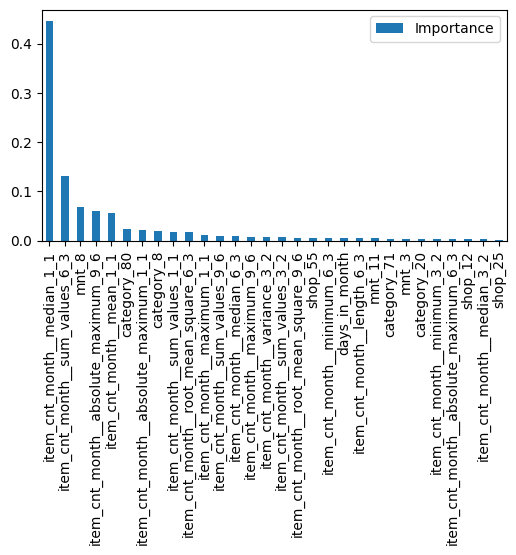

In [12]:
tree_model = list_models[-1]
feat_importances = pd.DataFrame(tree_model.feature_importances_, index=train_X.columns, columns=["Importance"])
feat_importances.sort_values(by='Importance', ascending=False, inplace=True)
feat_importances = feat_importances.head(30)
feat_importances.plot(kind='bar', figsize=(6,3))

### 4) Save model and make predictions
- Save model and write prediction to our database (in this case I just write to parquet file)
- When building model, we could use mlflow to track the model experiments and manage the best model as well

In [15]:
# Because testset only have features, no sales label
# so we do not need to store as variablej
test_X, _ = split_X_y(test)
test_pred = test[["id"]].copy()
test_pred["prediction"] = np.round(best_model.predict(test_X))

In [20]:
import pickle as pkl
output_dir = Path("../data/model")
pkl.dump(best_model, open(output_dir.joinpath("model.pkl"), "wb"))
test_pred.to_parquet(output_dir.joinpath("task1.parquet"), index=False)

In [22]:
pd.read_parquet(output_dir.joinpath("task1.parquet")).head(10)

,id,prediction
0,10-10003,1.0
1,10-10005,1.0
2,10-10007,1.0
3,10-10021,1.0
4,10-10027,1.0
5,10-10028,1.0
6,10-10029,1.0
7,10-10032,1.0
8,10-10039,1.0
9,10-10042,1.0


# Task 2
In this task, I break into steps:
- Model preparation: pre-computing approach
- API service: FastAPI/Flask/Django
- Deployment: batch processing + containerization
- Monitoring: data drift
- Source code management: GitHub

### 1) Model preparation 
To support for task 2, we need to generate predictions for all shop-item and as I checked, it has around 200K shop-item combinations. The number of combinations is small, and we do not need to make inference on the fly, therefore, pre-computing predictions approach is suitable.

#### Why pre-computing approach
__Pros__
Pros | Description 
-|-
Low latency | It has low latency and critical for real-time application (even the prediction is not real time)
Low resource | No heavy computational tasks such as model inference and feature extractions
Batch processing efficiency | Arrange time to schedule for the jobs to compute and refresh predictions

__Cons__
Cons | Description
-|-
Storage overhead | Storing predictions for large number of items can lead to increase storage overhead
Less flexibility | If we need real time user input such as user behavior change in seconds, and need to refresh the feature, this approach can not do that

- However, we have a limit set of shop-item and that number is small, using pre-computing predictions is suitable
- The storage cost is low (only costs about 1.8MB for ~200k predictions)

### 2) API to serve model
Based on the background of the team, we can choose FastAPI/Flask or Django, however, I really familiar with FastAPI or Flask than Django, I go for one of them, in this case it is FastAPI. The reason I choose to use FastAPI is because it is designed to build API while Flask is designed to build for both API and web UI (I like the `single responsibility` principal).

In this task, we only need to build one API to respond the prediction to user `/predict_sales`, this route receive two params:
- `shop_id`: int
- `item_id`: int

### 3) Model deployment
Once we have the solution and API to serve the model, a job to compute predictions every month is a need and the way to package our application is essential. We should use docker to build image, test it in our local machine and bring the image to wherever we want, docker ensures that the same image deliver the same results no matter what operating system you run (just in case that you run on different architecture which is not supported by that image, for ex: build in x86 and run on arm64). 

### 4) Model monitoring
To monitor our model performance over time, there are some metrics and concepts we need to put into consideration:
- Performance metrics: RMSE
- Data drift: use statistical tests to detect data drifts, or use tool like `evidently`
- Model drift: check the model performance through the performance metric over time (to check if it degrades)
- Logging and tracking: to monitor the model version, we could use `mlflow` to do so
- Setup automated re-train if data drfit or model drift detected

### 5) This is simple pipeline to predict for all shop-item combinations

In [35]:
import numpy as np
import pickle as pkl
from pathlib import Path
from model.dataset import Dataset
from model.feature import FeatureExtraction

In [25]:
dataset = Dataset("../data/raw")
feature = FeatureExtraction(dataset)

2024-09-21 15:28:54.055 | INFO     | model.dataset:_prepare_dataset:52 - Test date block num: 34


In [28]:
block_num = 34
data = dataset.generate(34, 1)
data = feature.add_features(data, 34)

Feature Extraction: 100%|██████████| 40/40 [00:06<00:00,  6.17it/s]


In [37]:
model_dir = Path("../data/model")
model = pkl.load(open(model_dir.joinpath("model.pkl"), "rb"))
X, _ = split_X_y(data)
y_hat = np.round(model.predict(X))


In [39]:
test_pred = data[["id"]].copy()
test_pred["prediction"] = y_hat
test_pred.head(3)

,id,prediction
0,3-20482,1.0
1,27-2235,2.0
2,17-1189,-0.0


In [40]:
output_dir = Path("../data/model")
test_pred.to_parquet(output_dir.joinpath("task2.parquet"), index=False)